In [ ]:
import os
import numpy as np
import random
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
from dataset import dataset
#from neural_network import neural_net
from additional_functions import process_all
from additional_functions import save_arrays_to_csv
from additional_functions import load_arrays_from_csv
from additional_functions import make_plots_2

# Neural Network Class w/ Backpropogation

In [ ]:
class backprop_nn:
    def __init__(self, data: dataset, prediction_type_flag: str, hidden_layer_count=0, network_shape=[], hidden_node_count=1, epochs=100, momentum=.9, learning_rate=.01, batch_size=10):
        self.epochs = epochs
        self.momentum = momentum
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.hidden_layer_count = hidden_layer_count
        if hidden_layer_count == 0:
            hidden_node_count = 0
        else:
            hidden_node_count = [hidden_node_count] * hidden_layer_count
        self.tune_set = data.tune_set
        self.validate_set = data.validate_set
        self.prediction_type = prediction_type_flag

        if self.prediction_type == "classification":
            self.class_count = len(np.unique(self.tune_set[:,-1]))
        else:
            self.class_count = 0

        input_size = self.tune_set.shape[1] - 1
        self.input_size = input_size
        if network_shape == []:
            self.network_shape = [input_size] + (hidden_node_count if hidden_node_count else []) + ([self.class_count] if (self.prediction_type == "classification") else [1])
        else:
            self.network_shape = network_shape
        self.biases = []
        self.weights = []
        self.bias_velocity = []
        self.weight_velocity = []
    def init_weights_biases_momentum(self):
        '''
        Initializes weights randomly based on the network shape list
        '''
        self.biases = [np.random.randn(next_size, 1) for next_size in self.network_shape[1:]]
        self.weights = [np.random.randn(next_size, cur_size) for cur_size, next_size in zip(self.network_shape[:-1], self.network_shape[1:])]
        self.bias_velocity = [np.zeros(bias.shape) for bias in self.biases]
        self.weight_velocity = [np.zeros(weight.shape) for weight in self.weights]
    def for_prop(self, input: np):
        '''
        Feeds forward a single example through the network
        '''
        output = input
        for bias, weight in zip(self.biases[:-1], self.weights[:-1]):
            output = self.sigmoid(np.dot(weight, output) + bias)        #for each weight calculate the output of the activation function
                
        bias, weight = self.biases[-1], self.weights[-1]
        #For regression, use a linear combination for output activation
        #For classification, use a softmax output activation
        output = (np.dot(weight, output) + bias)    
        if self.prediction_type == "classification":
            output = self.softmax(output)
        return output
    def get_training_data(self, i: int):
        '''
        method needs to take in training data and compile 9 of the 10 folds (not fold I) into an array
        we then want to format the data as follows: each example = (attributes, label)
        I is used to indicate which fold is the hold out fold
        '''
        desired_data = np.concatenate([self.validate_set[j] for j in range(10) if j != i])  #Get all folds other than fold I and compile into its own array
        training_data = [(example[:-1], example[-1]) for example in desired_data]   #Format properly
        return training_data
    def get_testing_data(self, i: int):
        '''
        method needs to take in training data and compile 1 of the 10 folds (fold I) into an array
        Then format the data as follows: each example = (attributes, label)
        i is used to indicate which training set you want returned
        '''
        desired_data = self.validate_set[i]         #Get the test set
        testing_data = [(example[:-1], example[-1]) for example in desired_data] #Format properly
        return testing_data
    def get_tuning_data(self):
        '''
        method needs to take in the tuning set and properly format it
        Then format the data as follows: each example = (attributes, label)
        i is used to indicate which training set you want returned
        '''
        desired_data = self.tune_set  #Get the tuning set
        tuning_data = [(example[:-1], example[-1]) for example in desired_data] #Format properly
        return tuning_data
    def grad_desc(self, training_data, epochs, momentum, learning_rate, batch_size):
        # ***THINK OF THIS METHOD AS TRAINING VIA BACKPROPOGATION*** #
        '''
        Takes in a traing set from get_training_data. The format is a list of tuples, where each tuple
        represents an example. Within each tuple the first value is the feature vector and the second
        value is the label.

        We want to complete mini batch gradient descent

        This method effectively trains the model
        '''
        example_count = len(training_data)
        for epoch in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+batch_size] for k in range(0, example_count, batch_size)]         #Form the mini batches based on the batch size hyperparameters
            for mini_batch in mini_batches:
                self.update_weights(mini_batch, momentum, learning_rate)                                        #for each mini batch, update the weights
    def update_weights(self, mini_batch, momentum, learning_rate):
        '''
        This method takes in a mini batch and the momentum and learning rate hyperparameters. It needs to compute the gradient
        for the biases and the weights, use the gradients to calculate the velocities, and use the velocities to update the weights
        and biases.
        '''
        bias_gradient = [np.zeros(bias.shape) for bias in self.biases]          #initialize an empty array to store the gradients
        weight_gradient = [np.zeros(weight.shape) for weight in self.weights]

        # Compute gradients for the mini-batch
        for feature, label in mini_batch:           
            if not np.isnan(label):
                delta_bias_gradient, delta_weight_gradient = self.epoch(feature, label)
                bias_gradient = [gradient + delta for gradient, delta in zip(bias_gradient, delta_bias_gradient)]
                weight_gradient = [gradient + delta for gradient, delta in zip(weight_gradient, delta_weight_gradient)]
        
        # Update velocities and apply updates with momentum
        self.bias_velocity = [momentum * velocity - (learning_rate / len(mini_batch)) * gradient for velocity, gradient in zip(self.bias_velocity, bias_gradient)]
        self.weight_velocity = [momentum * velocity - (learning_rate / len(mini_batch)) * gradient for velocity, gradient in zip(self.weight_velocity, weight_gradient)]

        # Update weights and biases
        self.biases = [bias + velocity for bias, velocity in zip(self.biases, self.bias_velocity)]
        self.weights = [bias + velocity for bias, velocity in zip(self.weights, self.weight_velocity)]
    def epoch(self, feature, label):
        '''
        This method should complete one full cycle of forward propogation, loss calculation, calculate gradients based on loss
        and back propogation to update weights. 
        '''
        
        bias_gradient = [np.zeros(bias.shape) for bias in self.biases]
        weight_gradient = [np.zeros(weight.shape) for weight in self.weights]
        #forprop
        activation = feature
        activations = [feature] # list to store all the activations
        weighted_inputs = []
        for bias, weight in zip(self.biases[:-1], self.weights[:-1]):
            weighted_input = np.dot(weight, activation.reshape(-1,1)) + bias
            activation = self.sigmoid(weighted_input)
            weighted_inputs.append(weighted_input)
            activations.append(activation)
        # The output layer uses different activation functions
        bias, weight = self.biases[-1], self.weights[-1]
        weighted_input = np.dot(weight, activation.reshape(-1,1)) + bias
        #weighted_input = np.dot(weight, activation)
        activation = weighted_input
        if self.prediction_type == "classification":
            activation = self.softmax(weighted_input)
        weighted_inputs.append(weighted_input)
        activations.append(activation)

    


        # backprop
       
        if self.prediction_type == "classification":
            one_hot_label = [0] * self.class_count
            one_hot_label[int(label)] = 1
            one_hot_label = np.array(one_hot_label).reshape(-1, 1)
        else:
            one_hot_label = label       
        delta = (activations[-1] - one_hot_label) # * self.softmax(weighted_inputs[-1])
        bias_gradient[-1] = delta
        
        weight_gradient[-1] = np.dot(delta, activations[-2].reshape(1,-1))

        for layer_idx in range(2, len(self.network_shape)):
            weighted_input = weighted_inputs[-layer_idx]
            activation_prime = self.sigmoid_prime(weighted_input)
            delta = np.dot(self.weights[-layer_idx+1].transpose(), delta) * activation_prime
            
            if delta.shape == (1,1):
                bias_gradient[-layer_idx] = delta.reshape(-1)
                weight_gradient[-layer_idx] = (delta.reshape(-1) * activations[-layer_idx-1].transpose())
            else:
                bias_gradient[-layer_idx] = delta
                weight_gradient[-layer_idx] = np.dot(delta, activations[-layer_idx-1].reshape(1,-1))       
        return (bias_gradient, weight_gradient)
    def tune(self):
        '''
        The method should test the hyperparameter values below and return the combination of hyperparameters
        that result in the best performance for the algorithm.
        '''
        hidden_node_vals = [1, 3, 5, 7, 9]
        epoch_vals = [10, 50, 100, 200, 500]
        momentum_vals = [0.5, 0.7, 0.9, 0.95, 0.99]
        learning_rate_vals = [0.0001, 0.001, 0.01, 0.1, 1.0]
        batch_size_vals = [16, 32, 64, 128, 256]

        hidden_node_scores = []
        epoch_scores = []
        momentum_scores = []
        learning_rate_scores = []
        batch_size_scores = []

        # Hidden node Count Tuning
        '''
        If there is only one hidden layer try all five possible values and return the values that leads to best performance
        If there are two hiddens layers complete a grid search with the five possible values and return the combination that performs the best
        '''
        if (self.hidden_layer_count > 0):       #skip if there are no hidden layers
            hidden_node_combinations = list(itertools.product(hidden_node_vals, repeat=self.hidden_layer_count))
            for combination in tqdm(hidden_node_combinations, desc="Tuning Hidden Node Count", leave=False):
                self.network_shape = [self.input_size] + (list(combination)) + ([self.class_count] if (self.prediction_type == "classification") else [1])
                hidden_node_score = self.train_test(tuning_flag=True, epochs=self.epochs, momentum=self.momentum, learning_rate=self.learning_rate, batch_size=self.batch_size)
                hidden_node_scores.append(np.mean(hidden_node_score))
            hidden_node_scores = np.array(hidden_node_scores)
            if self.prediction_type == "classification":
                self.network_shape = [self.input_size] + (list(hidden_node_combinations[np.argmax(hidden_node_scores)])) + ([self.class_count] if (self.prediction_type == "classification") else [1])
            else:
                self.network_shape = [self.input_size] + (list(hidden_node_combinations[np.argmin(hidden_node_scores)])) + ([self.class_count] if (self.prediction_type == "classification") else [1])          
            print(f"Tuned Network Shape: {self.network_shape}")

        # Epoch tuning
        #Test all five epoch values above and return the value that performs the best
        for epochs in tqdm(epoch_vals, desc="Tuning Epochs", leave=False):
            epoch_score = self.train_test(tuning_flag=True, epochs=epochs, momentum=self.momentum, learning_rate=self.learning_rate, batch_size=self.batch_size)
            epoch_scores.append(np.mean(epoch_score))
        epoch_scores = np.array(epoch_scores)
        if self.prediction_type == "classification":
            self.epochs = epoch_vals[np.argmax(epoch_scores)]
        else:
            self.epochs = epoch_vals[np.argmin(epoch_scores)]
        print(f"Tuned Epoch Value: {self.epochs}")

        # Momentum Tuning
        #Try all five momentum values and return the value that performs the best
        for momentum in tqdm(momentum_vals, desc="Tuning Momentum", leave=False):
            momentum_score = self.train_test(tuning_flag=True, epochs=self.epochs, momentum=momentum, learning_rate=self.learning_rate, batch_size=self.batch_size)
            momentum_scores.append(np.mean(momentum_score))
        momentum_scores = np.array(momentum_scores)
        if self.prediction_type == "classification":
            self.momentum = momentum_vals[np.argmax(momentum_scores)]
        else:
            self.momentum = momentum_vals[np.argmin(momentum_scores)]
        print(f"Tuned Momentum Value: {self.momentum}")

        # Learning rate tuning
        #Try all five learning rate values and return the value that performs the best
        for learning_rate in tqdm(learning_rate_vals, desc="Tuning Learning Rate", leave=False):
            learning_rate_score = self.train_test(tuning_flag=True, epochs=self.epochs, momentum=self.momentum, learning_rate=learning_rate, batch_size=self.batch_size)
            learning_rate_scores.append(np.mean(learning_rate_score))
        learning_rate_scores = np.array(learning_rate_scores)
        if self.prediction_type == "classification":
            self.learning_rate = learning_rate_vals[np.argmax(learning_rate_scores)]
        else:
            self.learning_rate = learning_rate_vals[np.argmin(learning_rate_scores)]
        print(f"Tuned Learning Rate: {self.learning_rate}")

        # Batch size tuning
        #Try all five momentum values and return the value that performs the best
        for batch_size in tqdm(batch_size_vals, desc="Tuning Batch Size", leave=False):
            batch_size_score = self.train_test(tuning_flag=True, epochs=self.epochs, momentum=self.momentum, learning_rate=self.learning_rate, batch_size=batch_size)
            batch_size_scores.append(np.mean(batch_size_score))
        batch_size_scores = np.array(batch_size_scores)
        if self.prediction_type == "classification":
            self.batch_size = batch_size_vals[np.argmax(batch_size_scores)]
        else:
            self.batch_size = batch_size_vals[np.argmin(batch_size_scores)]
        print(f"Tuned Batch Size: {self.batch_size}")

        return [self.network_shape, self.epochs, self.momentum, self.learning_rate, self.batch_size]
    def train_test(self, tuning_flag: bool, epochs=100, momentum=.9, learning_rate=.01, batch_size=10):
        '''
        This method should take in the hyperparameters determined during tuning. It should use those hyperparameter
        values to train and test the model and return the calculated loss scores
        '''
        scores = []
        if tuning_flag:
            for i in range(10):
                self.init_weights_biases_momentum()     
                self.grad_desc(self.get_training_data(i), epochs, momentum, learning_rate, batch_size)
                score = self.loss(self.get_tuning_data())
                scores.append(score)
        else:
            for i in tqdm(range(10), desc="Evaluating Test Data", leave=False):
                self.init_weights_biases_momentum()
                self.grad_desc(self.get_training_data(i), self.epochs, self.momentum, self.learning_rate, self.batch_size)
                score = self.loss(self.get_testing_data(i))
                scores.append(score)
        return np.array(scores)
    def loss(self, test_data):
        '''
        This method calculates the loss based on our evaluation metrics
        For classification: 0/1 loss
        For regression: Mean squared error
        '''
        if self.prediction_type == "classification":
            results = [(np.argmax(self.for_prop(example)), label) for (example, label) in test_data if not np.isnan(label)]
            correct_results = sum(int(example == label) for (example, label) in results)
            total_examples = len(results)
            return correct_results / total_examples
        else:
            results = [(self.for_prop(x), y) for (x, y) in test_data if not np.isnan(y)]
            # Ensure predictions and labels are both 1D arrays of the same length
            predictions = np.array([prediction.flatten()[0] if prediction.size == 1 else np.argmax(prediction) for (prediction, label) in results], dtype=float)
            labels = np.array([label for (prediction, label) in results], dtype=float)

            # Calculate MSE
            mse = np.mean((predictions - labels) ** 2)
            return mse
    def sigmoid(self, input: np):       #used the logistic function as our activation
        return 1.0/(1.0+np.exp(-input))
    def sigmoid_prime(self, input: np): #derivative of the logistic function
        return self.sigmoid(input)*(1-self.sigmoid(input))
    def softmax(self, input):   #softmax for output activation during classification
        exp = np.exp(input - np.max(input))
        return exp / np.sum(exp)    

In [ ]:
class DE_nn(backprop_nn):
    def __init__(self, data: dataset, prediction_type_flag: str, network_shape: list, population_size=100, epochs=100, scaling_factor=1, crossover_rate=1):
        self.epochs = epochs
        self.pop_size = population_size
        self.f = scaling_factor
        self.cr = crossover_rate
        self.tune_set = data.tune_set
        self.validate_set = data.validate_set
        self.prediction_type = prediction_type_flag

        if self.prediction_type == "classification":
            self.class_count = len(np.unique(self.tune_set[:,-1]))
        else:
            self.class_count = 0
            
        input_size = self.tune_set.shape[1] - 1
        self.input_size = input_size
        self.network_shape = network_shape
        self.biases = []
        self.weights = []
    
    '''
    def init_weights_biases_momentum(self):
    def for_prop(self, input: np):
    def get_training_data(self, i: int):
    def get_testing_data(self, i: int):
    def get_tuning_data(self):
    def train_test(self, tuning_flag: bool, epochs=100, momentum=.9, learning_rate=.01, batch_size=10):
    def loss(self, test_data):
    def sigmoid(self, input: np):       #used the logistic function as our activation
    def sigmoid_prime(self, input: np): #derivative of the logistic function
    def softmax(self, input):   #softmax for output activation during classification
    '''
        

# Backpropogation NN Instantiation

In [ ]:
abalone_data, cancer_data, fire_data, glass_data, machine_data, soybean_data = process_all('carlthedog3', True)

In [ ]:
# Classification Sets
cancer_net_0 = backprop_nn(cancer_data, "classification", hidden_layer_count=0, epochs=10,momentum=.5,learning_rate=.01,batch_size=16)
cancer_net_1 = backprop_nn(cancer_data, "classification", hidden_layer_count=1, network_shape=[9,1,2],epochs=50,momentum=.7,learning_rate=.1,batch_size=16)
cancer_net_2 = backprop_nn(cancer_data, "classification", hidden_layer_count=2, network_shape=[9,1,5,2],epochs=50,momentum=.9,learning_rate=.01,batch_size=16)

glass_net_0 = backprop_nn(glass_data, "classification", hidden_layer_count=0, epochs=100,momentum=.5,learning_rate=.001,batch_size=16)
glass_net_1 = backprop_nn(glass_data, "classification", hidden_layer_count=1, network_shape=[9,1,6],epochs=500,momentum=.95,learning_rate=.01,batch_size=32)
glass_net_2 = backprop_nn(glass_data, "classification", hidden_layer_count=2, network_shape=[9,1,9,6],epochs=500,momentum=.95,learning_rate=.01,batch_size=32)

soybean_net_0 = backprop_nn(soybean_data, "classification", hidden_layer_count=0, epochs=10,momentum=.99,learning_rate=.01,batch_size=16)
soybean_net_1 = backprop_nn(soybean_data, "classification", hidden_layer_count=1, network_shape=[35,1,4],epochs=500,momentum=.99,learning_rate=.01,batch_size=16)
soybean_net_2 = backprop_nn(soybean_data, "classification", hidden_layer_count=2, network_shape=[35,1,9,4],epochs=500,momentum=.95,learning_rate=.1,batch_size=256)


# Regression Sets
abalone_net_0 = backprop_nn(abalone_data, "regression", hidden_layer_count=0, epochs=200,momentum=.9,learning_rate=.01,batch_size=32)
abalone_net_1 = backprop_nn(abalone_data, "regression", hidden_layer_count=1, network_shape=[8,1,1],epochs=500,momentum=.95,learning_rate=.01,batch_size=16)
abalone_net_2 = backprop_nn(abalone_data, "regression", hidden_layer_count=2, network_shape=[8,1,9,1],epochs=500,momentum=.99,learning_rate=.001,batch_size=16)

fire_net_0 = backprop_nn(fire_data, "regression", hidden_layer_count=0, epochs=200,momentum=.9,learning_rate=.01,batch_size=16)
fire_net_1 = backprop_nn(fire_data, "regression", hidden_layer_count=1, network_shape=[12,1,1],epochs=200,momentum=.95,learning_rate=.01,batch_size=16)
fire_net_2 = backprop_nn(fire_data, "regression", hidden_layer_count=2, network_shape=[12,1,1,1],epochs=500,momentum=.95,learning_rate=.001,batch_size=16)

machine_net_0 = backprop_nn(machine_data, "regression", hidden_layer_count=0, epochs=500,momentum=.95,learning_rate=.01,batch_size=16)
machine_net_1 = backprop_nn(machine_data, "regression", hidden_layer_count=1, network_shape=[9,1,1],epochs=500,momentum=.99,learning_rate=.01,batch_size=16)
machine_net_2 = backprop_nn(machine_data, "regression", hidden_layer_count=2, network_shape=[9,1,7,1],epochs=500,momentum=.99,learning_rate=.01,batch_size=16)

# Abalone Tuning + Final Scores

In [ ]:
#abalone_net_0_parameters = abalone_net_0.tune()
abalone_0_score = abalone_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_0_score)}")

KeyboardInterrupt: 

In [ ]:
#abalone_net_1_parameters = abalone_net_1.tune()
abalone_1_score = abalone_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_1_score)}")

Average Performance: 0.006559091413981334


In [ ]:
#abalone_net_2_parameters = abalone_net_2.tune()
abalone_2_score = abalone_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_2_score)}")

Average Performance: 0.006931437623464018


# Fire Tuning + Final Scores

In [ ]:
#fire_net_0_parameters = fire_net_0.tune()
fire_0_score = fire_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_0_score)}")

Average Performance: 0.005721274142668384


In [ ]:
#fire_net_1_parameters = fire_net_1.tune()
fire_1_score = fire_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_1_score)}")

Average Performance: 0.0037049092062057245


In [ ]:
#fire_net_2_parameters = fire_net_2.tune()
fire_2_score = fire_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_2_score)}")

Average Performance: 0.0037254296840037344


# Machine Tuning + Final Scores

In [ ]:
#machine_net_0_parameters = machine_net_0.tune()
machine_0_score = machine_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_0_score)}")

Average Performance: 0.0010733058271575635


In [ ]:
#machine_net_1_parameters = machine_net_1.tune()
machine_1_score = machine_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_1_score)}")

Average Performance: 0.006593045274298735


In [ ]:
#machine_net_2_parameters = machine_net_2.tune()
machine_2_score = machine_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_2_score)}")

Average Performance: 0.004282514017486736


# Cancer Tuning + Final Scores

In [ ]:
#cancer_net_0_parameters = cancer_net_0.tune()
cancer_0_score = cancer_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_0_score)}")

Average Performance: 0.42910906298003065


In [ ]:
#cancer_net_1_parameters = cancer_net_1.tune()
cancer_1_score = cancer_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_1_score)}")

Average Performance: 0.9650281618023552


In [ ]:
#cancer_net_2_parameters = cancer_net_2.tune()
cancer_2_score = cancer_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_2_score)}")

Average Performance: 0.9682027649769583


# Glass Tuning + Final Scores

In [ ]:
#glass_net_0_parameters = glass_net_0.tune()
glass_0_score = glass_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_0_score)}")

Average Performance: 0.010263157894736842


In [ ]:
#glass_net_1_parameters = glass_net_1.tune()
glass_1_score = glass_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_1_score)}")

Average Performance: 0.58


In [ ]:
#glass_net_2_parameters = glass_net_2.tune()
glass_2_score = glass_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_2_score)}")

Average Performance: 0.59


# Soybean Tuning + Final Scores

In [ ]:
#soybean_net_0_parameters = soybean_net_0.tune()
soybean_0_score = soybean_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_0_score)}")

Average Performance: 0.125


In [ ]:
#soybean_net_1_parameters = soybean_net_1.tune()
soybean_1_score = soybean_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_1_score)}")

Average Performance: 0.765


In [ ]:
#soybean_net_2_parameters = soybean_net_2.tune()
soybean_2_score = soybean_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_2_score)}")

Average Performance: 0.8800000000000001


# Plotting Metrics

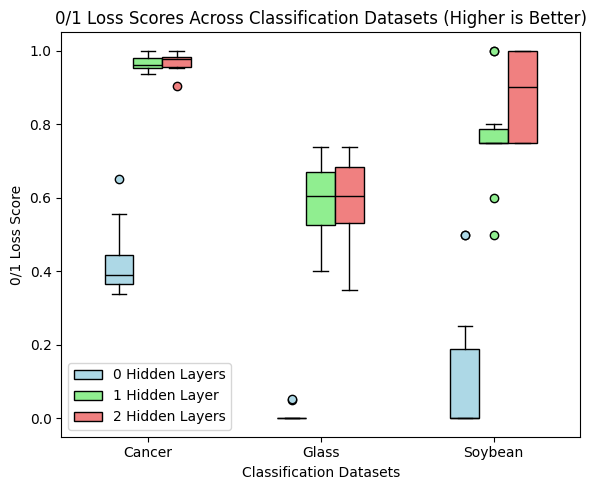

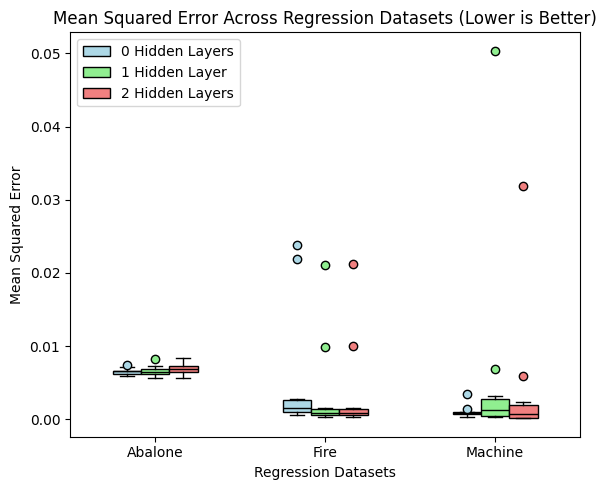

In [3]:
#classification_arrays = [cancer_0_score,cancer_1_score,cancer_2_score,
#                         glass_0_score,glass_1_score,glass_2_score,
#                         soybean_0_score,soybean_1_score,soybean_2_score]
#regression_arrays = [abalone_0_score,abalone_1_score,abalone_2_score,
#                     fire_0_score,fire_1_score,fire_2_score,
#                     machine_0_score,machine_1_score,machine_2_score]
#arrays_to_save = []
#arrays_to_save.extend(classification_arrays)
#arrays_to_save.extend(regression_arrays)
#print(arrays_to_save)
#save_arrays_to_csv(arrays_to_save, 'results.csv')
loaded_arrays = load_arrays_from_csv('results.csv')
#loaded_arrays[1] = cancer_1_score
classification_arrays = loaded_arrays[:9]
regression_arrays = loaded_arrays[9:]
#loaded_arrays = classification_arrays
#loaded_arrays.extend(regression_arrays)
classification_dataset_names = ['Cancer', 'Glass', 'Soybean']
regression_dataset_names = ['Abalone', 'Fire', 'Machine']

make_plots_2(loaded_arrays, classification_dataset_names, regression_dataset_names, (6, 5), 0, '/home/carlthedog3/CSCI_447/Project_3/Code/Figures/')